In [1]:
import requests
url = 'https://apitempo.inmet.gov.br/estacao/2022-04-09/2022-07-09/A201'
resultado = requests.get(url)

In [2]:
import json
dados_org = resultado.json()
dados_str = json.dumps(dados_org)


In [3]:
import pandas as pd
import numpy as np

In [4]:
dados_tabla = pd.read_json(dados_str)
dados_tabla

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,...,VEN_VEL,PTO_MIN,TEM_MAX,TEN_BAT,VEN_RAJ,TEM_CPU,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO
0,BELÉM,1009.6,28.7,-1.411228,1009.6,PA,-1.3,24.0,25.4,-48.439512,...,0.3,24.0,25.6,13.1,2.8,27.0,25.5,91.0,A201,0
1,BELÉM,1009.9,28.5,-1.411228,1009.9,PA,-2.8,24.0,25.1,-48.439512,...,0.0,23.9,25.6,13.0,3.9,27.0,25.1,94.0,A201,100
2,BELÉM,1009.8,28.0,-1.411228,1010.0,PA,-2.6,23.9,24.6,-48.439512,...,0.0,23.8,25.1,13.0,1.7,26.0,24.6,96.0,A201,200
3,BELÉM,1009.7,28.2,-1.411228,1010.0,PA,-1.2,23.9,24.6,-48.439512,...,0.0,23.8,24.8,13.0,2.1,26.0,24.8,95.0,A201,300
4,BELÉM,1009.0,28.0,-1.411228,1009.7,PA,-2.4,23.8,24.5,-48.439512,...,0.0,23.7,24.8,13.0,2.0,26.0,24.6,96.0,A201,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,BELÉM,1008.1,34.9,-1.411228,1008.8,PA,2092.8,24.3,31.4,-48.439512,...,0.5,22.4,32.8,14.5,5.9,37.0,32.7,61.0,A201,1900
2204,BELÉM,1008.0,32.2,-1.411228,1008.3,PA,1142.7,23.3,31.0,-48.439512,...,2.0,22.4,32.7,14.1,5.0,37.0,31.0,64.0,A201,2000
2205,BELÉM,1009.0,28.8,-1.411228,1009.2,PA,138.8,23.3,27.3,-48.439512,...,1.9,23.3,31.0,13.1,8.2,33.0,27.3,79.0,A201,2100
2206,BELÉM,1010.5,24.7,-1.411228,1010.5,PA,11.5,23.1,25.6,-48.439512,...,3.8,22.9,27.2,13.0,8.2,30.0,25.6,86.0,A201,2200


In [5]:
dados = dados_tabla[['DT_MEDICAO', 'HR_MEDICAO', 'TEM_INS', 'UMD_INS', 'RAD_GLO']]
dados

,DT_MEDICAO,HR_MEDICAO,TEM_INS,UMD_INS,RAD_GLO
0,2022-04-09,0,25.5,91.0,-1.3
1,2022-04-09,100,25.1,94.0,-2.8
2,2022-04-09,200,24.6,96.0,-2.6
3,2022-04-09,300,24.8,95.0,-1.2
4,2022-04-09,400,24.6,96.0,-2.4
...,...,...,...,...,...
2203,2022-07-09,1900,32.7,61.0,2092.8
2204,2022-07-09,2000,31.0,64.0,1142.7
2205,2022-07-09,2100,27.3,79.0,138.8
2206,2022-07-09,2200,25.6,86.0,11.5


# Renomia o titulo do nosso dados

In [6]:
dados.columns = ['DATA','HORARIO', 'TEMPERATURA', 'UMIDADE', 'RADIACAO']

In [7]:
dados

,DATA,HORARIO,TEMPERATURA,UMIDADE,RADIACAO
0,2022-04-09,0,25.5,91.0,-1.3
1,2022-04-09,100,25.1,94.0,-2.8
2,2022-04-09,200,24.6,96.0,-2.6
3,2022-04-09,300,24.8,95.0,-1.2
4,2022-04-09,400,24.6,96.0,-2.4
...,...,...,...,...,...
2203,2022-07-09,1900,32.7,61.0,2092.8
2204,2022-07-09,2000,31.0,64.0,1142.7
2205,2022-07-09,2100,27.3,79.0,138.8
2206,2022-07-09,2200,25.6,86.0,11.5


<AxesSubplot:title={'center':'TEMPERATURA'}, xlabel='HORARIO'>

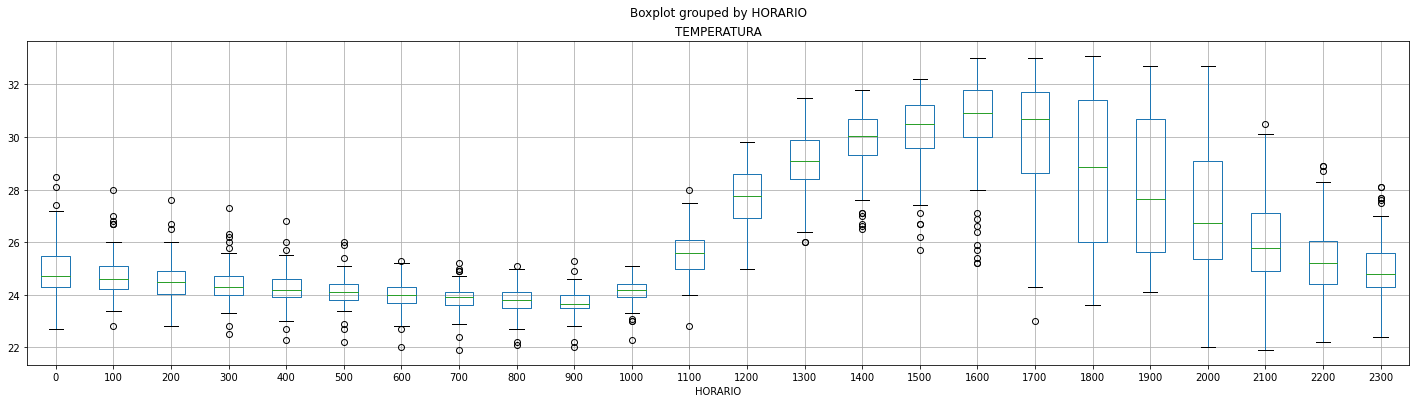

In [8]:
dados.boxplot("TEMPERATURA", by='HORARIO', figsize=(24,6))

<AxesSubplot:title={'center':'UMIDADE'}, xlabel='HORARIO'>

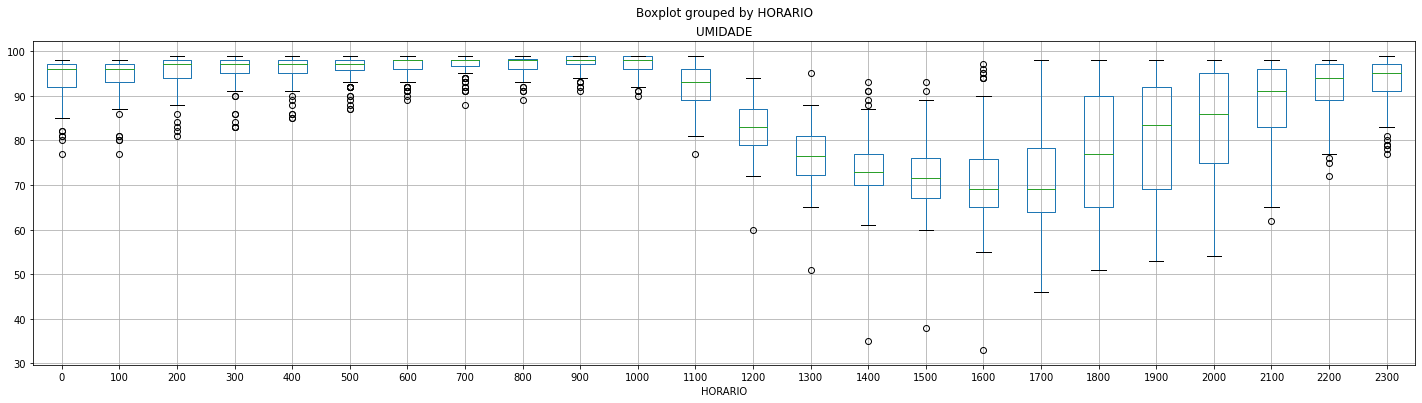

In [9]:
dados.boxplot("UMIDADE", by='HORARIO', figsize=(24,6))

<AxesSubplot:title={'center':'RADIACAO'}, xlabel='HORARIO'>

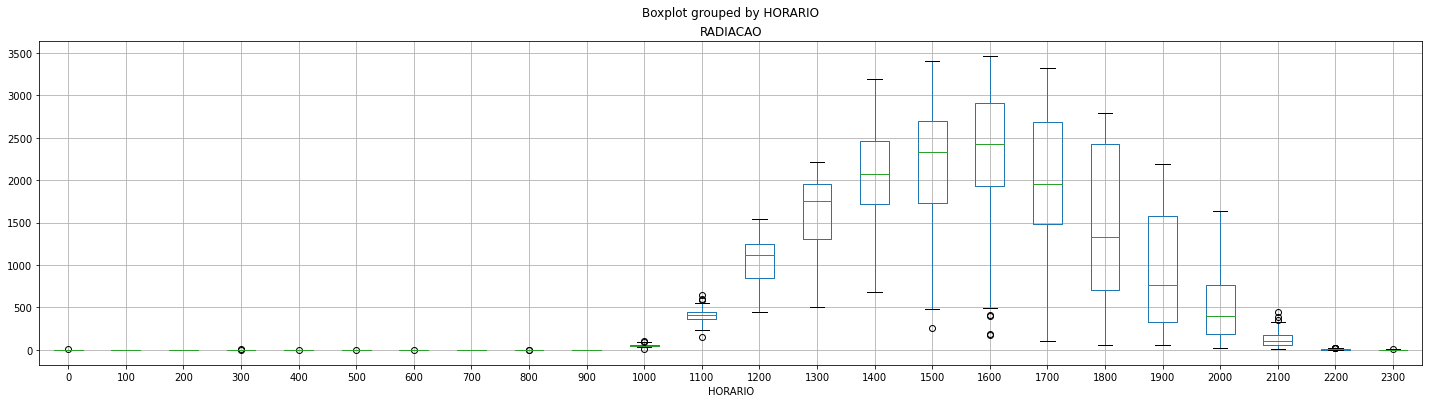

In [10]:
dados.boxplot("RADIACAO", by='HORARIO', figsize=(24,6))

# Verificando a suma de dados null 

In [11]:
dados.apply(pd.isnull).sum()/dados.shape[0]

DATA           0.000000
HORARIO        0.000000
TEMPERATURA    0.113225
UMIDADE        0.120924
RADIACAO       0.113225
dtype: float64

In [12]:
dados[pd.isnull(dados['TEMPERATURA'])]

,DATA,HORARIO,TEMPERATURA,UMIDADE,RADIACAO
1492,2022-06-10,400,NaN,NaN,NaN
1493,2022-06-10,500,NaN,NaN,NaN
1494,2022-06-10,600,NaN,NaN,NaN
1495,2022-06-10,700,NaN,NaN,NaN
1496,2022-06-10,800,NaN,NaN,NaN
...,...,...,...,...,...
1737,2022-06-20,900,NaN,NaN,NaN
1738,2022-06-20,1000,NaN,NaN,NaN
1878,2022-06-26,600,NaN,NaN,NaN
1883,2022-06-26,1100,NaN,NaN,NaN


In [13]:
dados = dados.fillna(method='ffill')

In [14]:
dados.apply(pd.isnull).sum()/dados.shape[0]

DATA           0.0
HORARIO        0.0
TEMPERATURA    0.0
UMIDADE        0.0
RADIACAO       0.0
dtype: float64

# verificando se nosso dados são numéricos

In [15]:
dados.dtypes

DATA            object
HORARIO          int64
TEMPERATURA    float64
UMIDADE        float64
RADIACAO       float64
dtype: object

<AxesSubplot:title={'center':'TEMPERATURA'}, xlabel='DATA'>

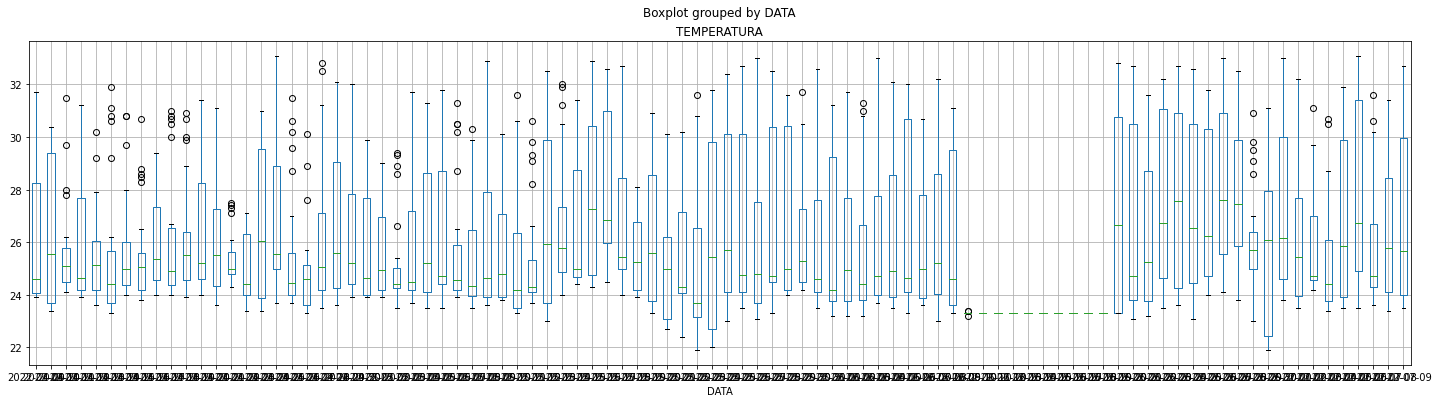

In [16]:
dados.boxplot("TEMPERATURA", by='DATA', figsize=(24,6))

<AxesSubplot:>

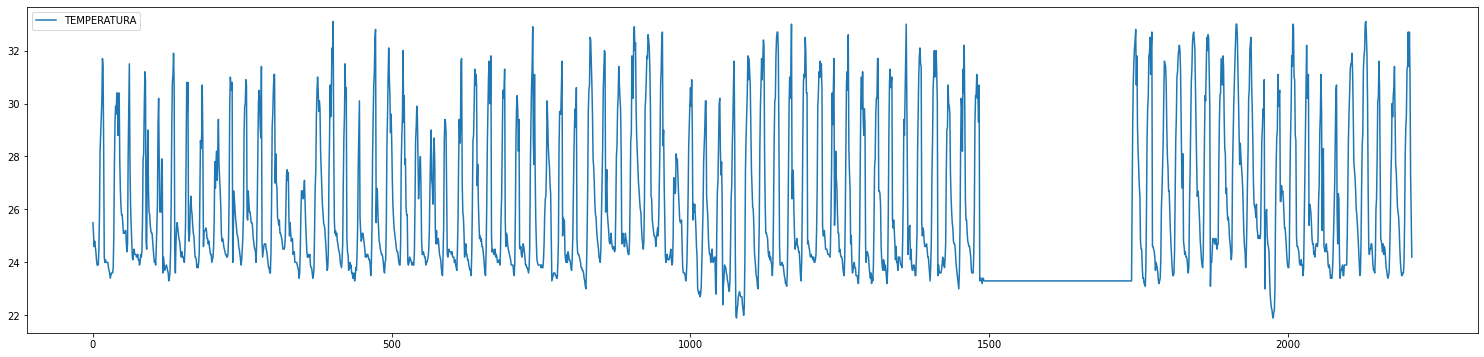

In [17]:
dados[['TEMPERATURA']].plot(figsize=(26,6))

# Agrupando os dados por horário

In [18]:
dados.groupby(dados.HORARIO).sum()

,TEMPERATURA,UMIDADE,RADIACAO
HORARIO,,,
0,2275.5,8628.0,-68.8
100,2262.1,8679.0,-89.4
200,2247.8,8736.0,-124.6
300,2236.9,8771.0,-127.3
400,2224.0,8807.0,-139.3
500,2211.3,8837.0,-156.4
600,2201.4,8875.0,-164.8
700,2191.2,8901.0,-169.7
800,2183.2,8916.0,-171.9


### Criando novos colunas para Temperatura da amahão, Umidade da amahão e Radiação da amahão na tabla  

In [19]:
dados

,DATA,HORARIO,TEMPERATURA,UMIDADE,RADIACAO
0,2022-04-09,0,25.5,91.0,-1.3
1,2022-04-09,100,25.1,94.0,-2.8
2,2022-04-09,200,24.6,96.0,-2.6
3,2022-04-09,300,24.8,95.0,-1.2
4,2022-04-09,400,24.6,96.0,-2.4
...,...,...,...,...,...
2203,2022-07-09,1900,32.7,61.0,2092.8
2204,2022-07-09,2000,31.0,64.0,1142.7
2205,2022-07-09,2100,27.3,79.0,138.8
2206,2022-07-09,2200,25.6,86.0,11.5


### Criando novos colunas para Temperatura da amahão, Umidade da amahão e Radiação da amahão na tabla 

In [20]:
dados['TEMP_AMANHAO'] = dados.shift(-1)['TEMPERATURA']
dados['TEMP_MES_MIX'] = dados['TEMPERATURA'].rolling(30).mean()

In [21]:
dados['UMID_AMANHAO'] = dados.shift(-1)['UMIDADE']
dados['UMID_MES_MIX'] = dados['UMIDADE'].rolling(30).mean()

In [22]:
dados['RADI_AMANHAO'] = dados.shift(-1)['RADIACAO']
dados['RADI_MES_MIX'] = dados['RADIACAO'].rolling(30).mean()

In [23]:
dados['HORARIO_ATUAL'] = dados.shift(3)['HORARIO']

### Deletando NULL

In [24]:
dados = dados.iloc[30:,:].copy()
dados = dados.iloc[:-1, :].copy()

In [25]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha=0.01, solver='auto', fit_intercept=True, max_iter=None, tol=0.001, copy_X=True)

In [26]:
from sklearn.metrics import mean_absolute_percentage_error

In [27]:
numerio_de_dados = (len(dados)+8)/2

In [28]:
def criar_previsões_temp(preditores, dados, reg):
    trinar = dados.loc[:numerio_de_dados]
    teste = dados.loc[numerio_de_dados:]
    reg.fit(trinar[preditores], trinar["TEMPERATURA"])
    preditores = reg.predict(teste[preditores])
    erro = mean_absolute_percentage_error(teste["TEMPERATURA"],preditores)
    conjunto = pd.concat([teste['TEMPERATURA'], pd.Series(preditores, index=teste.index )], axis=1)
    conjunto.columns = ['ATUAL_TEMPERATURA', 'PREVISOES_TEMPERATURA']
    conjunto[['DATA','HORARIO']] = teste[['DATA','HORARIO_ATUAL']]
    return erro, conjunto

In [29]:
def criar_previsões_umid(preditores, dados, reg):
    trinar = dados.loc[:numerio_de_dados]
    teste = dados.loc[numerio_de_dados:]
    reg.fit(trinar[preditores], trinar["UMIDADE"])
    preditores = reg.predict(teste[preditores])
    erro = mean_absolute_percentage_error(teste["UMIDADE"],preditores)
    conjunto = pd.concat([teste["UMIDADE"], pd.Series(preditores, index=teste.index)], axis=1)
    conjunto.columns = ["ATUAL_UMIDADE", "PREVISOES_UMIDADE"]
    return erro, conjunto

In [30]:
def criar_previsões_radi(preditores, dados, reg):
    trinar = dados.loc[:numerio_de_dados]
    teste = dados.loc[numerio_de_dados:]
    reg.fit(trinar[preditores], trinar["RADIACAO"])
    preditores = reg.predict(teste[preditores])
    erro = mean_absolute_percentage_error(teste["RADIACAO"],preditores)
    conjunto = pd.concat([teste["RADIACAO"], pd.Series(preditores, index=teste.index)], axis=1)
    conjunto.columns = ["ATUAL_RADIACAO", "PREVISOES_RADIACAO"]
    return erro, conjunto

In [31]:
preditores = ['HORARIO', 'TEMPERATURA','UMIDADE','RADIACAO','TEMP_MES_MIX', 'UMID_MES_MIX','RADI_MES_MIX']

In [32]:
temp_erro, temp_prevesao = criar_previsões_temp(preditores, dados, reg)

In [33]:
umid_erro, umid_prevesao = criar_previsões_umid(preditores, dados, reg)

In [34]:
radi_erro, radi_prevesao = criar_previsões_radi(preditores, dados, reg)

In [35]:
previsoes_dados = temp_prevesao

In [36]:
previsoes_dados[["ATUAL_UMIDADE", "PREVISOES_UMIDADE"]] = umid_prevesao[["ATUAL_UMIDADE", "PREVISOES_UMIDADE"]]

In [37]:
previsoes_dados

,ATUAL_TEMPERATURA,PREVISOES_TEMPERATURA,DATA,HORARIO,ATUAL_UMIDADE,PREVISOES_UMIDADE
1093,28.7,28.699995,2022-05-24,1000.0,78.0,77.999999
1094,29.6,29.599990,2022-05-24,1100.0,77.0,76.999998
1095,30.4,30.400003,2022-05-24,1200.0,68.0,68.000001
1096,31.8,31.799992,2022-05-24,1300.0,65.0,65.000000
1097,30.9,30.899977,2022-05-24,1400.0,70.0,70.000000
...,...,...,...,...,...,...
2202,31.4,31.400007,2022-07-09,1500.0,60.0,60.000002
2203,32.7,32.699977,2022-07-09,1600.0,61.0,60.999999
2204,31.0,30.999979,2022-07-09,1700.0,64.0,64.000002
2205,27.3,27.299991,2022-07-09,1800.0,79.0,79.000002


In [38]:
previsoes_dados[["ATUAL_RADIACAO", "PREVISOES_RADIACAO"]] = radi_prevesao[["ATUAL_RADIACAO", "PREVISOES_RADIACAO"]]

In [39]:
previsoes_dados = previsoes_dados[['DATA','HORARIO','ATUAL_TEMPERATURA','PREVISOES_TEMPERATURA','ATUAL_UMIDADE','PREVISOES_UMIDADE','ATUAL_RADIACAO','PREVISOES_RADIACAO']]

In [40]:
garoadb = previsoes_dados[['DATA','HORARIO','PREVISOES_TEMPERATURA','PREVISOES_UMIDADE','PREVISOES_RADIACAO']]

In [41]:
garoadb

,DATA,HORARIO,PREVISOES_TEMPERATURA,PREVISOES_UMIDADE,PREVISOES_RADIACAO
1093,2022-05-24,1000.0,28.699995,77.999999,1984.2
1094,2022-05-24,1100.0,29.599990,76.999998,2302.9
1095,2022-05-24,1200.0,30.400003,68.000001,2667.2
1096,2022-05-24,1300.0,31.799992,65.000000,2904.6
1097,2022-05-24,1400.0,30.899977,70.000000,1952.1
...,...,...,...,...,...
2202,2022-07-09,1500.0,31.400007,60.000002,2389.4
2203,2022-07-09,1600.0,32.699977,60.999999,2092.8
2204,2022-07-09,1700.0,30.999979,64.000002,1142.7
2205,2022-07-09,1800.0,27.299991,79.000002,138.8


In [42]:
h0 = garoadb[garoadb['HORARIO'] == 0.0]
T0 = h0['PREVISOES_TEMPERATURA'].median()
U0 = h0['PREVISOES_UMIDADE'].median()
R0 = h0['PREVISOES_RADIACAO'].median()

h1 = garoadb[garoadb['HORARIO'] == 100.0]
T1 = h1['PREVISOES_TEMPERATURA'].median()
U1 = h1['PREVISOES_UMIDADE'].median()
R1 = h1['PREVISOES_RADIACAO'].median()

h2 = garoadb[garoadb['HORARIO'] == 200.0]
T2 = h2['PREVISOES_TEMPERATURA'].median()
U2 = h2['PREVISOES_UMIDADE'].median()
R2 = h2['PREVISOES_RADIACAO'].median()

h3 = garoadb[garoadb['HORARIO'] == 300.0]
T3 = h3['PREVISOES_TEMPERATURA'].median()
U3 = h3['PREVISOES_UMIDADE'].median()
R3 = h3['PREVISOES_RADIACAO'].median()

h4 = garoadb[garoadb['HORARIO'] == 400.0]
T4 = h4['PREVISOES_TEMPERATURA'].median()
U4 = h4['PREVISOES_UMIDADE'].median()
R4 = h4['PREVISOES_RADIACAO'].median()

h5 = garoadb[garoadb['HORARIO'] == 500.0]
T5 = h5['PREVISOES_TEMPERATURA'].median()
U5 = h5['PREVISOES_UMIDADE'].median()
R5 = h5['PREVISOES_RADIACAO'].median()

h6 = garoadb[garoadb['HORARIO'] == 600.0]
T6 = h6['PREVISOES_TEMPERATURA'].median()
U6 = h6['PREVISOES_UMIDADE'].median()
R6 = h6['PREVISOES_RADIACAO'].median()

h7 = garoadb[garoadb['HORARIO'] == 700.0]
T7 = h7['PREVISOES_TEMPERATURA'].median()
U7 = h7['PREVISOES_UMIDADE'].median()
R7 = h7['PREVISOES_RADIACAO'].median()

h8 = garoadb[garoadb['HORARIO'] == 800.0]
T8 = h8['PREVISOES_TEMPERATURA'].median()
U8 = h8['PREVISOES_UMIDADE'].median()
R8 = h8['PREVISOES_RADIACAO'].median()

h9 = garoadb[garoadb['HORARIO'] == 900.0]
T9 = h9['PREVISOES_TEMPERATURA'].median()
U9 = h9['PREVISOES_UMIDADE'].median()
R9 = h9['PREVISOES_RADIACAO'].median()

h10 = garoadb[garoadb['HORARIO'] == 1000.0]
T10 = h10['PREVISOES_TEMPERATURA'].median()
U10 = h10['PREVISOES_UMIDADE'].median()
R10 = h10['PREVISOES_RADIACAO'].median()

h11 = garoadb[garoadb['HORARIO'] == 1100.0]
T11 = h11['PREVISOES_TEMPERATURA'].median()
U11 = h11['PREVISOES_UMIDADE'].median()
R11 = h11['PREVISOES_RADIACAO'].median()

h12 = garoadb[garoadb['HORARIO'] == 1200.0]
T12 = h12['PREVISOES_TEMPERATURA'].median()
U12 = h12['PREVISOES_UMIDADE'].median()
R12 = h12['PREVISOES_RADIACAO'].median()

h13 = garoadb[garoadb['HORARIO'] == 1300.0]
T13 = h13['PREVISOES_TEMPERATURA'].median()
U13 = h13['PREVISOES_UMIDADE'].median()
R13 = h13['PREVISOES_RADIACAO'].median()

h14 = garoadb[garoadb['HORARIO'] == 1400.0]
T14 = h14['PREVISOES_TEMPERATURA'].median()
U14 = h14['PREVISOES_UMIDADE'].median()
R14 = h14['PREVISOES_RADIACAO'].median()

h15 = garoadb[garoadb['HORARIO'] == 1500.0]
T15 = h15['PREVISOES_TEMPERATURA'].median()
U15 = h15['PREVISOES_UMIDADE'].median()
R15 = h15['PREVISOES_RADIACAO'].median()

h16 = garoadb[garoadb['HORARIO'] == 1600.0]
T16 = h16['PREVISOES_TEMPERATURA'].median()
U16 = h16['PREVISOES_UMIDADE'].median()
R16 = h16['PREVISOES_RADIACAO'].median()

h17 = garoadb[garoadb['HORARIO'] == 1700.0]
T17 = h17['PREVISOES_TEMPERATURA'].median()
U17 = h17['PREVISOES_UMIDADE'].median()
R17 = h17['PREVISOES_RADIACAO'].median()

h18 = garoadb[garoadb['HORARIO'] == 1800.0]
T18 = h18['PREVISOES_TEMPERATURA'].median()
U18 = h18['PREVISOES_UMIDADE'].median()
R18 = h18['PREVISOES_RADIACAO'].median()

h19 = garoadb[garoadb['HORARIO'] == 1900.0]
T19 = h19['PREVISOES_TEMPERATURA'].median()
U19 = h19['PREVISOES_UMIDADE'].median()
R19 = h19['PREVISOES_RADIACAO'].median()

h20 = garoadb[garoadb['HORARIO'] == 2000.0]
T20 = h20['PREVISOES_TEMPERATURA'].median()
U20 = h20['PREVISOES_UMIDADE'].median()
R20 = h20['PREVISOES_RADIACAO'].median()

h21 = garoadb[garoadb['HORARIO'] == 2100.0]
T21 = h21['PREVISOES_TEMPERATURA'].median()
U21 = h21['PREVISOES_UMIDADE'].median()
R21 = h21['PREVISOES_RADIACAO'].median()

h22 = garoadb[garoadb['HORARIO'] == 2200.0]
T22 = h22['PREVISOES_TEMPERATURA'].median()
U22 = h22['PREVISOES_UMIDADE'].median()
R22 = h22['PREVISOES_RADIACAO'].median()

h23 = garoadb[garoadb['HORARIO'] == 2300.0]
T23 = h23['PREVISOES_TEMPERATURA'].median()
U23 = h23['PREVISOES_UMIDADE'].median()
R23 = h23['PREVISOES_RADIACAO'].median()

garoadb2 = pd.DataFrame([(T0,U0,R0),
                         (T1,U1,R1),
                         (T2,U2,R2),
                         (T3,U3,R3),
                         (T4,U4,R4),
                         (T5,U5,R5),
                         (T6, U6, R6),
                        (T7, U7, R7),
                        (T8, U8, R8),
                        (T9, U9, R9),
                        (T10, U10, R10),
                        (T11, U11, R11),
                        (T12, U12, R12),
                        (T13, U13, R13),
                        (T14, U14, R14),
                        (T15, U15, R15),
                        (T16, U16, R16),
                        (T17, U17, R17),
                        (T18, U18, R18),
                        (T19, U19, R19),
                        (T20, U20, R20),
                        (T21, U21, R21),
                        (T22, U22, R22),
                        (T23, U23, R23)
                                        ])
                         


In [43]:
garoadb2.columns = ['TEM_INS','UMD_INS','RAD_GLO']

In [44]:
garoadb2['HR_MEDICAO'] = pd.DataFrame([(0),
 (100),(200),(300),(400),(500),(600),(700),(800),(900),(1000),(1100),(1200),(1300),(1400),(1500),(1600),(1700),(1800),(1900),(2000),(2100),(2200),(2300)])

In [45]:
garoadb2['DT_MEDICAO']= pd.DataFrame([('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09'),
('2022-07-09')])

In [46]:
garoadb2

,TEM_INS,UMD_INS,RAD_GLO,HR_MEDICAO,DT_MEDICAO
0,24.149998,96.999996,-1.90,0,2022-07-09
1,23.950004,96.999997,-1.90,100,2022-07-09
2,23.850006,96.999999,-1.90,200,2022-07-09
3,23.750007,97.000000,-1.90,300,2022-07-09
4,23.550009,97.500000,-2.20,400,2022-07-09
5,23.500010,98.000000,-2.20,500,2022-07-09
6,23.450011,98.000000,-2.10,600,2022-07-09
7,23.900001,97.999999,41.00,700,2022-07-09
8,25.299999,92.000000,399.40,800,2022-07-09
9,27.400005,82.999999,1138.75,900,2022-07-09


In [47]:
garoadb2.DT_MEDICAO = pd.to_datetime(garoadb2.DT_MEDICAO)

In [48]:
garoadb3 = garoadb2[['DT_MEDICAO','HR_MEDICAO','TEM_INS','UMD_INS','RAD_GLO']]

In [49]:
garoadb3

,DT_MEDICAO,HR_MEDICAO,TEM_INS,UMD_INS,RAD_GLO
0,2022-07-09,0,24.149998,96.999996,-1.90
1,2022-07-09,100,23.950004,96.999997,-1.90
2,2022-07-09,200,23.850006,96.999999,-1.90
3,2022-07-09,300,23.750007,97.000000,-1.90
4,2022-07-09,400,23.550009,97.500000,-2.20
5,2022-07-09,500,23.500010,98.000000,-2.20
6,2022-07-09,600,23.450011,98.000000,-2.10
7,2022-07-09,700,23.900001,97.999999,41.00
8,2022-07-09,800,25.299999,92.000000,399.40
9,2022-07-09,900,27.400005,82.999999,1138.75


In [50]:
garoadb3.to_csv('garoaDB1.csv', index=False)

<AxesSubplot:title={'center':'TEM_INS'}, xlabel='HR_MEDICAO'>

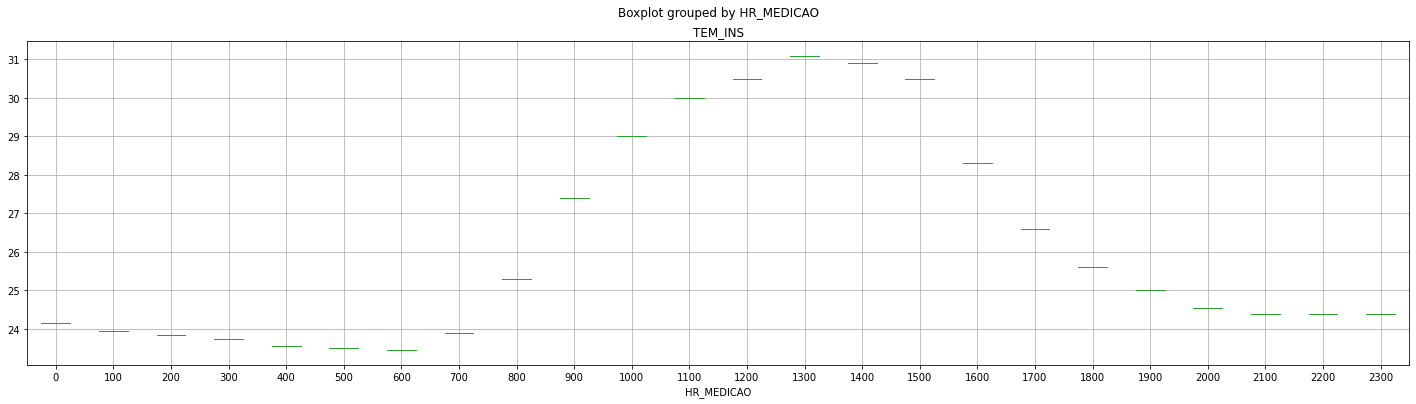

In [51]:
garoadb2.boxplot("TEM_INS", by='HR_MEDICAO', figsize=(24,6))

<AxesSubplot:title={'center':'UMD_INS'}, xlabel='HR_MEDICAO'>

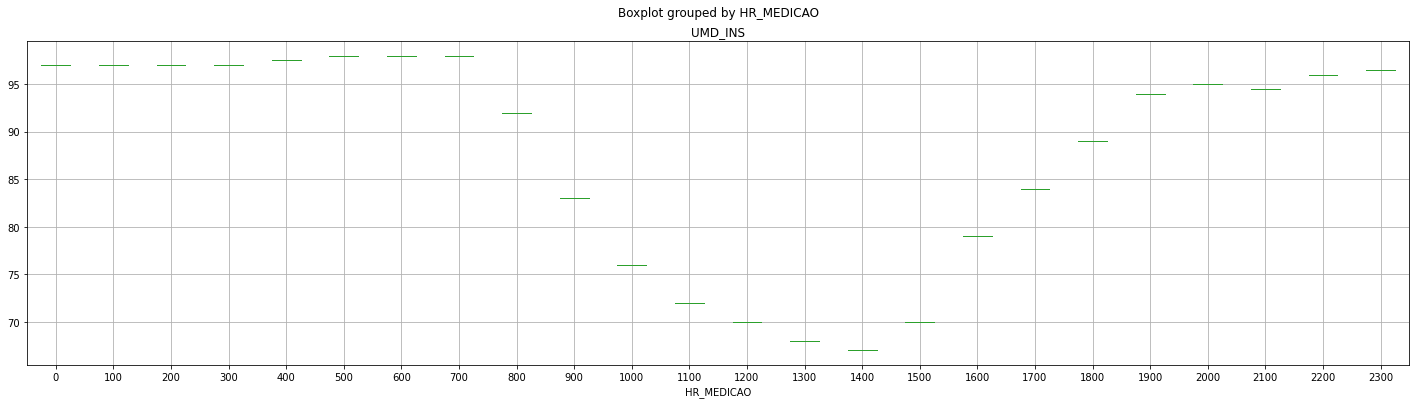

In [52]:
garoadb2.boxplot("UMD_INS", by='HR_MEDICAO', figsize=(24,6))


<AxesSubplot:title={'center':'RAD_GLO'}, xlabel='HR_MEDICAO'>

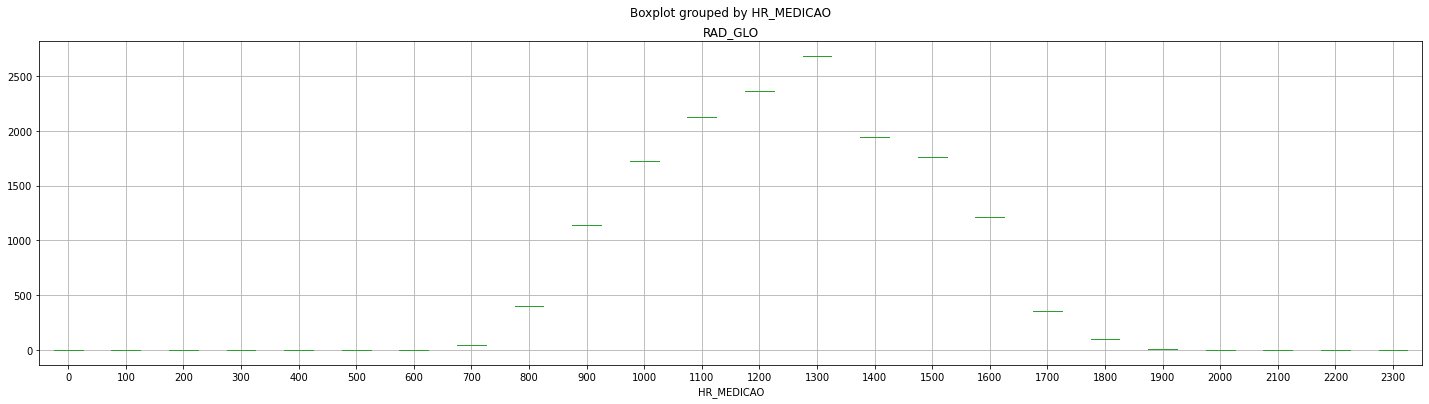

In [53]:
garoadb2.boxplot("RAD_GLO", by='HR_MEDICAO', figsize=(24,6))


In [54]:
umid_erro

1.630907092537236e-08

In [55]:
temp_erro

3.0684918042832933e-07

In [56]:
radi_erro

45789.0627691597

<AxesSubplot:title={'center':'PREVISOES_TEMPERATURA'}, xlabel='HORARIO'>

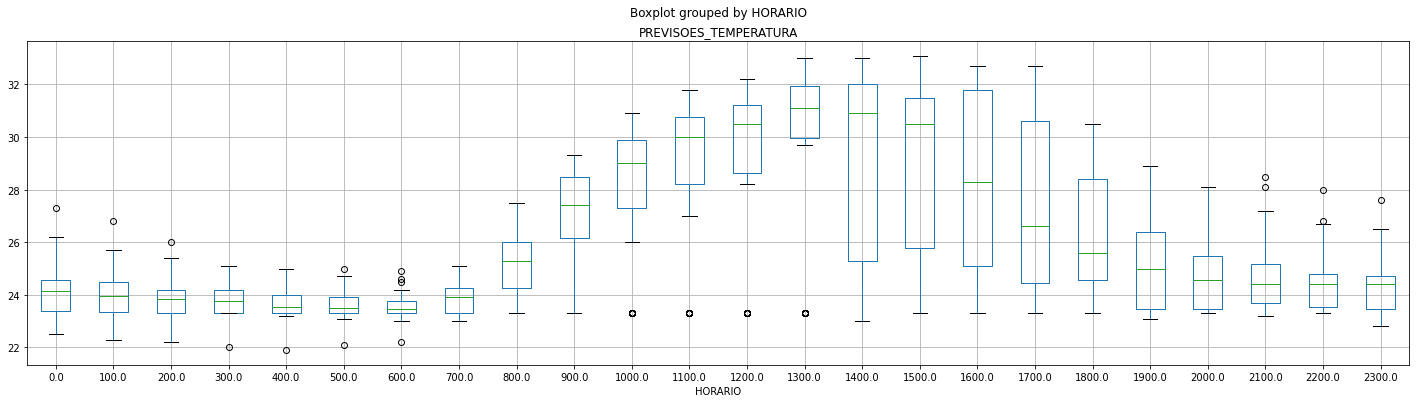

In [57]:
previsoes_dados.boxplot("PREVISOES_TEMPERATURA", by='HORARIO', figsize=(24,6))

<AxesSubplot:title={'center':'PREVISOES_UMIDADE'}, xlabel='HORARIO'>

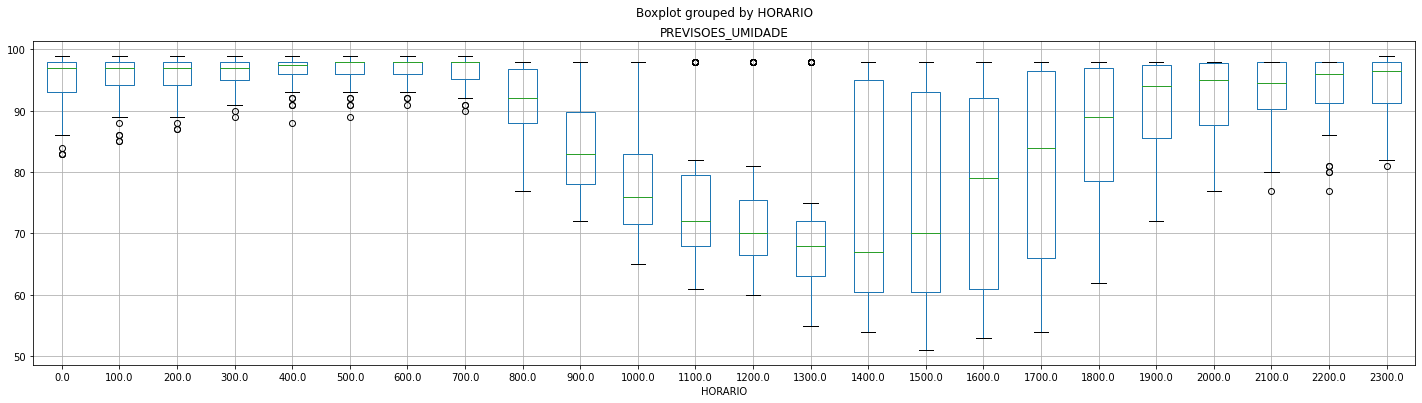

In [58]:
previsoes_dados.boxplot("PREVISOES_UMIDADE", by='HORARIO', figsize=(24,6))


<AxesSubplot:title={'center':'PREVISOES_RADIACAO'}, xlabel='HORARIO'>

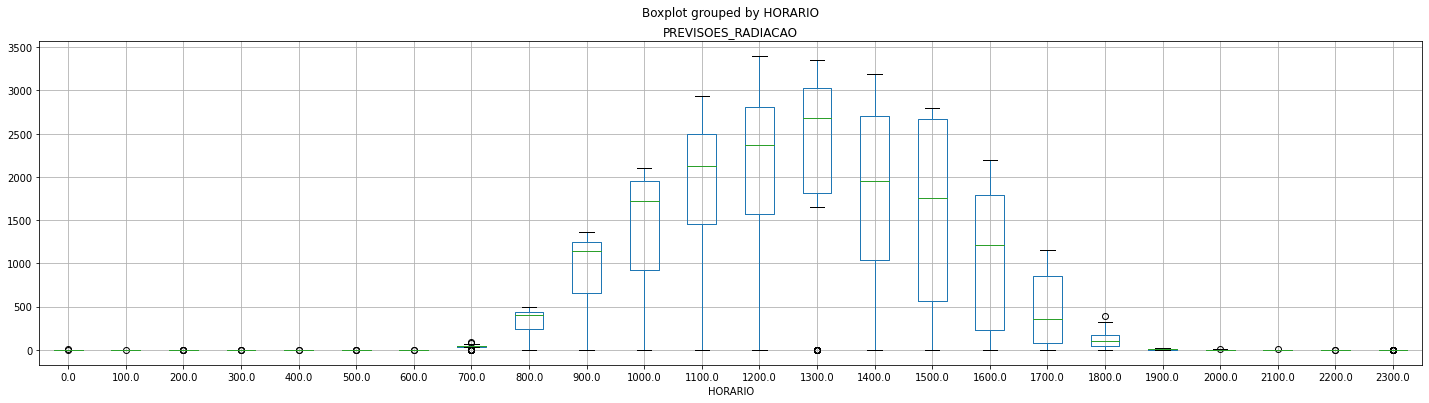

In [59]:
previsoes_dados.boxplot("PREVISOES_RADIACAO", by='HORARIO', figsize=(24,6))